# Word Embedding
이번 실습파일에서는 '포스코'를 검색했을 때 나오는 블로그 글을 전처리하고, 4개의 범주로 나눈 다음, 시각화 하는 단계를 진행해 보겠습니다 😀.

아래는 진행 내용입니다.

1. 세 가지 기준으로 text 전처리
  - over_2 : 두번 이상 나온 단어만 사용
  - 명사만 사용
  - 불필요한 단어 제거

2. 전처리 된 텍스트를 이용해서 임베딩
  - counter vectorize 를 먼저 만들고
  - TF-IDF 를 다음으로 만듬

3. 임베딩을 이용해서 클러스터링 진행
  - 블로그 글을 주제별로 4개로 클러스터링 해보자

4. 시각화
  - 워드 클라우드 그려보기


## 0. 필요한 모듈 import


In [1]:
# 한국어 폰트 다운로드
# 런타임 -->  세션 다시시작 필요

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (17.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126101 files and direc

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter # element 개수 셀 때 사용
from wordcloud import WordCloud

In [3]:
!pip install konlpy
import konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 33.7 MB/s eta 0:00:00


In [4]:
# clustering
! pip install soyclustering
from sklearn.feature_extraction.text import CountVectorizer # 벡터화
from sklearn.feature_extraction.text import TfidfTransformer # tfidf
from soyclustering import SphericalKMeans # clustering

In [8]:
from google.colab import files
file = files.upload()

Saving naver_blog.json to naver_blog.json


## 0. 데이터 읽어오기
블로그 포스코 검색 결과로 저장한 json 파일 로드

In [9]:
df_blog = pd.read_json("./naver_blog.json")
df_blog.head()

,title,link,description,bloggername,bloggerlink,postdate
0,뷰티풀 민트 라이프 2023 뮤직 페스티벌 뷰민라 <b>포스코</b> 팝업...,https://blog.naver.com/pih870318/223103807388,2023 뮤직 페스티벌 뷰민라 뷰티풀 민트 라이프 <b>포스코</b> 팝업 포석호 ...,초코혜 365일 매일이 여행 ♪,blog.naver.com/pih870318,20230516
1,♣ 5월 <b>포스코</b> 그룹주 주가 흐름,https://blog.naver.com/photoman75/223101456174,"© traxer, 출처 Unsplash <b>포스코</b> 그룹주가 3월 이후 수급...",숨 그리고 삶,blog.naver.com/photoman75,20230514
2,문현 <b>포스코</b> 센트럴포레 부적격세대 알아보세요,https://blog.naver.com/guen1600/223071175085,문현 <b>포스코</b> 센트럴포레 부적격세대 선착순 공급안내 문현 센트럴포레 <b...,돈 걱정 없는 인생 만들기,blog.naver.com/guen1600,20230411
3,문현 <b>포스코</b> 센트럴포레 문현동 마루 아파트,https://blog.naver.com/sanbok91/223086651151,문현 <b>포스코</b> 센트럴포레 문현동 마루 아파트 정부의 부동산 규제 완화책 ...,부동산스토리,blog.naver.com/sanbok91,20230427
4,문현 <b>포스코</b> 센트럴포레 부적격세대 현장소식,https://blog.naver.com/wpthdud0/223085508053,문현 센트럴포레 - 시공사 <b>포스코</b> 건설 2022년 4월 사업승인 신청을...,하하하이모의 부동산정보,blog.naver.com/wpthdud0,20230426


##### description 내용만 list로 반환

In [10]:
descriptions = df_blog["description"].to_list() # 블로그 내용
descriptions[0:3]

['2023 뮤직 페스티벌 뷰민라 뷰티풀 민트 라이프 <b>포스코</b> 팝업 포석호 캐릭터 인증샷 이벤트까지... 이번 뷰티풀 민트 라이프 2023에는 게보린, <b>포스코</b>, 뮤직카우 등의 부스를 만날 수 있었는데요. 사실 <b>포스코</b>에서... ',
 '© traxer, 출처 Unsplash <b>포스코</b> 그룹주가 3월 이후 수급이 몰리면서 급등한 후 4월 20일 이후 조정을 받으며 하락하고 있다. <b>포스코</b>인터내셔널은 <b>포스코</b>그룹주중에서 가장 늦게 발동이 걸리며 4월 13일 종가 22,250원... ',
 '문현 <b>포스코</b> 센트럴포레 부적격세대 선착순 공급안내 문현 센트럴포레 <b>포스코</b> 아파트는 부산광역시 남구 문현동 334번지 일원에 위치하는 지역주택조합 아파트입니다. <b>포스코</b> 건설이 시공할 예정이며... ']

## 1. 세가지 기준으로 전처리
- 2번이상 나온
- 명사
- stop list 제거


### KoNLPy: 파이썬 한국어 NLP
- 형태소 분석
 - Hannanum: 한나눔. KAIST Semantic Web Research Center 개발
 - Kkma: 꼬꼬마. 서울대학교 IDS 연구실 개발
 - Komoran: 코모란. Shineware에서 개발
 - Mecab: 메카브. 일본어용 형태소 분석기를 한국어를 사용할 수 있도록 수정
 - Open Korean Text: 오픈 소스 한국어 분석기. 과거 트위터 형태소 분석기

*참고: https://datascienceschool.net/03%20machine%20learning/03.01.02%20KoNLPy%20%ED%95%9C%EA%B5%AD%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%ED%8C%A8%ED%82%A4%EC%A7%80.html

##### Question: Okt를 활용하여 첫 번째 문장의 형태소를 분석해보자

In [11]:
# !pip install knolpy
from konlpy.tag import Okt

parser_kor = Okt()
parser_kor.pos(descriptions[0])[:10]

[('2023', 'Number'),
 ('뮤직', 'Noun'),
 ('페스티벌', 'Noun'),
 ('뷰민', 'Noun'),
 ('라', 'Josa'),
 ('뷰티풀', 'Noun'),
 ('민트', 'Noun'),
 ('라이프', 'Noun'),
 ('<', 'Punctuation'),
 ('b', 'Alpha')]

##### Question: descriptions의 모든 문장의 형태소를 분석해보자

In [12]:
morphs = []         # 단어를 담을 리스트
for sentence in descriptions:                     # 리스트에서 각 문장 추출
    morphs.append(parser_kor.pos(sentence))  # 문장별 형태소 분석 결과 추가

In [13]:
morphs[16]

[('오늘', 'Noun'),
 ('은', 'Josa'),
 ('<', 'Punctuation'),
 ('b', 'Alpha'),
 ('>', 'Punctuation'),
 ('포스코', 'Noun'),
 ('</', 'Punctuation'),
 ('b', 'Alpha'),
 ('>', 'Punctuation'),
 ('퓨처엠', 'Noun'),
 ('의', 'Josa'),
 ('PEG', 'Alpha'),
 ('에', 'Josa'),
 ('대해', 'Noun'),
 ('서', 'Josa'),
 ('이야기', 'Noun'),
 ('를', 'Josa'),
 ('해본다', 'Verb'),
 ('.', 'Punctuation'),
 ('PEG', 'Alpha'),
 ('=', 'Punctuation'),
 ('Price', 'Alpha'),
 ('Earing', 'Alpha'),
 ('to', 'Alpha'),
 ('Growth', 'Alpha'),
 ('rate', 'Alpha'),
 ('월', 'Noun'),
 ('가의', 'Noun'),
 ('...', 'Punctuation'),
 ('구분', 'Noun'),
 ('A', 'Alpha'),
 ('기업', 'Noun'),
 ('B', 'Alpha'),
 ('기업', 'Noun'),
 ('주가', 'Noun'),
 ('1000', 'Number'),
 ('1000', 'Number'),
 ('EPS', 'Alpha'),
 ('40', 'Number'),
 ('100', 'Number'),
 ('PER', 'Alpha'),
 ('25', 'Number'),
 ('10', 'Number'),
 ('EPSG', 'Alpha'),
 ('50%', 'Number'),
 ('10%', 'Number'),
 ('PEG', 'Alpha'),
 ('0.5', 'Number'),
 ('1', 'Number'),
 ('<', 'Punctuation'),
 ('b', 'Alpha'),
 ('>', 'Punctuation'),
 ('

##### Question: descriptions의 모든 문장에서 명사만 추출해보자

In [14]:
noun_list=[]  # 명사만 모은 리스트 ,sentence 단위 아님
for wt in morphs: # description 별 pos tagging결과 # 리스트-문장 (pos)
    noun_list += [word for word, tag in wt if tag == 'Noun' ]

In [15]:
print(", ".join(noun_list))

뮤직, 페스티벌, 뷰민, 뷰티풀, 민트, 라이프, 포스코, 팝업, 포석, 호, 캐릭터, 인증샷, 이벤트, 이번, 뷰티풀, 민트, 라이프, 게보린, 포스코, 뮤직, 등, 부스, 만날, 수, 사실, 포스코, 출처, 포스코, 그룹, 주가, 이후, 수급, 급등, 후, 이후, 조정, 하락, 포스코, 인터내셔널, 포스코, 그룹, 주중, 가장, 발동, 종가, 현, 포스코, 센트럴, 포레, 부적, 격, 세대, 선착순, 공급, 안내, 현, 센트럴, 포레, 포스코, 아파트, 부산광역시, 남구, 문현동, 번지, 일원, 위치, 지역, 주택조합, 아파트, 포스코, 건설, 시공, 예정, 현, 포스코, 센트럴, 포레, 문현동, 마루, 아파트, 정부, 부동산, 규제, 완화, 책, 이후, 여러, 지표, 개선, 측면, 양호, 입지, 지역, 주택조합, 아파트, 현, 포스코, 센트럴, 포레, 소개, 현, 센트럴, 포레, 시공사, 포스코, 건설, 사업, 승인, 신청, 사업, 승인, 오늘, 중, 생활환경, 화제, 현, 포스코, 센트럴, 포레, 대해, 현, 포스코, 센트럴, 포레, 문현동, 아파트, 조합원, 선착순, 마루, 지역, 주택조합, 부산광역시, 남구, 문현동, 번지, 일원, 사업, 부지, 현, 포스코, 센트럴, 포레, 사업, 승인, 접수, 소식, 조합원, 자격, 현, 포스코, 센트럴, 포레, 문현동, 아파트, 분양, 정보, 부적, 격, 세대, 이번, 시즌, 가장, 핫, 곳, 수, 현, 포스코, 센트럴, 포레, 아파트, 공급, 소식, 마루, 지역, 주택조합, 부적, 격, 세대, 마지막, 포스코, 건설, 신규, 아파트, 연동, 더, 애비뉴, 공급, 제주, 연동, 포스코, 더, 주한, 병원, 주변, 위치, 것, 확인, 수, 주한, 병원, 포스코, 엠텍, 리튬, 리튬, 주, 말, 이, 회사, 철광석, 산소, 분리, 고순, 알루미늄, 탈산제, 직접, 생산, 기업, 포스코, 의, 직계, 회사, 중, 현, 포스코, 센트럴, 포레, 남구, 최, 중심, 위치, 현장, 면적, 제곱미터, 현, 포스코, 센트럴,

##### Question: 각 명사가 출현한 빈도를 체크해보자

In [16]:
Counter(noun_list).most_common(10)

[('포스코', 223),
 ('그룹', 23),
 ('사업', 23),
 ('홀딩스', 23),
 ('주가', 21),
 ('오늘', 17),
 ('주', 15),
 ('기업', 15),
 ('현', 13),
 ('센트럴', 13)]

##### Question: 2번이 넘게 나온 단어들 목록을 탐색하고, 불필요한 명사 리스트를 만들어보자

In [17]:
worddict = Counter(noun_list) # key : 단어, value : 등장횟수
over_2_noun = [k for k, v in worddict.items() if int(v)>2]
over_2_noun

['포스코',
 '팝업',
 '이번',
 '등',
 '수',
 '사실',
 '그룹',
 '주가',
 '이후',
 '급등',
 '후',
 '하락',
 '인터내셔널',
 '가장',
 '현',
 '센트럴',
 '포레',
 '부적',
 '격',
 '세대',
 '공급',
 '안내',
 '아파트',
 '남구',
 '문현동',
 '번지',
 '일원',
 '위치',
 '지역',
 '주택조합',
 '건설',
 '예정',
 '마루',
 '정부',
 '소개',
 '시공사',
 '사업',
 '승인',
 '오늘',
 '중',
 '대해',
 '접수',
 '소식',
 '분양',
 '정보',
 '핫',
 '곳',
 '연동',
 '더',
 '제주',
 '병원',
 '것',
 '확인',
 '엠텍',
 '리튬',
 '주',
 '이',
 '회사',
 '기업',
 '의',
 '엠',
 '실적',
 '미래',
 '주식',
 '퓨처엠',
 '기록',
 '내',
 '스틸',
 '리온',
 '상한',
 '홀딩스',
 '케미칼',
 '부문',
 '별',
 '소재',
 '위',
 '상승',
 '인터네셔널',
 '그',
 '기술',
 '분석',
 '투자자',
 '최근',
 '에코',
 '프로',
 '개인',
 '매수',
 '섹터',
 '철강',
 '및',
 '시간',
 '분',
 '위해',
 '설명',
 '한국',
 '를',
 '최대',
 '건물',
 '퓨처',
 '패턴',
 '대한',
 '어제',
 '종목',
 '관련',
 '전',
 '전자',
 '포스팅',
 '한번',
 '프로비',
 '업체',
 '상승세',
 '배터리',
 '제',
 '시작',
 '다른',
 '공장',
 '주로',
 '장',
 '관심',
 '상생',
 '스마트',
 '지원',
 '사거리',
 '센터',
 '테라로사',
 '점',
 '때',
 '동탄',
 '대장',
 '한화',
 '길',
 '삼성',
 '타입',
 '금',
 '지난',
 '이차전지',
 '준비',
 '장주',
 '밸류',
 '체인',
 '날',
 '사진',
 '아주',
 

In [18]:
# 불필요한 단어 리스트
removelist = ['포스코', '것', '중', '수', '이', '등', '대해', '비', '더', '가기', '의',
              '또', '명', '후', '좀', '별', '율', '나', '분', '무', '및', '뷰', '엠','주', '현', '은', '는', '를']

In [19]:
description_noun_2_list = []

for morph in morphs:
  noun = [w for (w,_) in morph if w in over_2_noun and w not in removelist]
  description_noun_2_list.append(noun)
print(description_noun_2_list[0]) # list로 저장됨

# 다시 줄글로 바꿔줘야함


description_noun_2 = []
for description_list in description_noun_2_list:
  description_noun_2.append(' '.join(description_list))
print(description_noun_2[0])




['팝업', '이번', '사실']
팝업 이번 사실


### 2. 전처리 된 텍스트를 이용해서 임베딩


In [20]:
# 문장 -> 벡터화 (TF-IDF) -> 비슷한 벡터끼리 모으기 --> 클러스터가 만들어짐
# TF-IDF 하려면 counter vecterizer를 만들어야함


vectorizer = CountVectorizer() # 한국어 pos, 명사, freq>2
X = vectorizer.fit_transform(description_noun_2) # 한국어를 잘하게 된다.
X
# 100 : 전체 document 수 ( 블로그 글 갯수)
# 395 : 명사, frequency 2 이상인 명사들의 집합

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 609 stored elements and shape (100, 161)>

In [21]:
vectorizer.get_feature_names_out()

array(['가장', '강남구', '개인', '건물', '건설', '골든', '공급', '공장', '관련', '관심', '교육',
       '규모', '그룹', '급등', '기록', '기술', '기업', '기자', '남구', '다과', '다른', '단지',
       '대장', '대한', '동탄', '디자인', '리온', '리튬', '마련', '마루', '매도', '매수', '면접',
       '문현동', '미래', '박물관', '발표', '배터리', '밸류', '번지', '병원', '보유', '부문',
       '부적', '분석', '분양', '사거리', '사무소', '사실', '사업', '사옥', '사진', '삼성', '상생',
       '상승', '상승세', '상한', '서울', '설명', '세대', '섹터', '센터', '센트럴', '소개', '소식',
       '소재', '솔루션', '스마트', '스토어', '스틸', '승인', '시간', '시공사', '시작', '신문',
       '실적', '아주', '아파트', '안내', '어제', '업체', '에스', '에코', '엠텍', '역사', '연동',
       '연수구', '예정', '오늘', '용솟음', '위치', '위해', '유튜브', '윤리', '이번', '이차전지',
       '이후', '인천', '인터내셔널', '인터네셔널', '일반', '일원', '자회사', '장주', '전자', '접수',
       '정도', '정말', '정보', '정부', '제작', '제주', '제철', '종목', '주가', '주로', '주식',
       '주택조합', '준비', '지구', '지난', '지역', '지원', '차트', '채널', '채용', '철강', '체인',
       '최근', '최대', '최정우', '캔커피', '케미칼', '타워', '타입', '테라로사', '투자', '투자자',
       '판매', '팝업', '패턴', '포레', '포스팅', '포항', '퓨처

In [22]:
X.toarray()[0] # 첫번째 블로그 글, 0 이 이미 많음

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [23]:
tfidf = TfidfTransformer()
# X " counter vectorize result"
X_tfidf = tfidf.fit_transform(X)

In [24]:
X.toarray()[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [25]:
X_tfidf.toarray()[0] # 중요도를 곱해줌

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.57373419, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

## 3. clustering
- 텍스트를 벡터화 완료
- 벡터끼리의 연산 가능해짐


##### Spherical k-means
- sparse vector의 clustering을 위해 활용
- cosine distance 활용
- 모든 데이터 포인트를 unit vector가 되도록 변형해서 이용
- centroid로 한 군집에 포함된 모든 벡터의 평균을 사용하지 않고, 벡터의 합을 L2 normalize 하여 centroid를 unit vector로 만듦
- 특별한 initialize 방법 사용

This package is implementation of Improving spherical k-means for document clustering: Fast initialization, sparse centroid projection, and efficient cluster labeling (Kim et al., 2020).

##### spherical k-means 인스턴스 생성 및 학습
cluster 수 = 4

In [26]:
np.int = np.int32
kmeans = SphericalKMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(X_tfidf)
labels

array([0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 1, 3, 1, 3, 3, 0, 1, 3, 0,
       0, 3, 1, 1, 3, 3, 0, 0, 1, 1, 0, 3, 3, 1, 3, 1, 2, 3, 0, 0, 2, 2,
       0, 0, 0, 1, 0, 3, 2, 1, 3, 0, 2, 0, 1, 0, 3, 0, 1, 0, 0, 1, 0, 0,
       3, 0, 0, 0, 1, 0, 3, 3, 1, 3, 2, 2, 0, 0, 2, 1, 0, 0, 2, 1, 2, 0,
       0, 3, 0, 0, 1, 1, 0, 3, 1, 0, 1, 1])

In [27]:
# descriptions, clustering 결과 dataframe 생성
df_descriptions = pd.DataFrame({"description": description_noun_2, "label": labels})
df_descriptions.head()

,description,label
0,팝업 이번 사실,0
1,그룹 주가 이후 급등 이후 하락 인터내셔널 그룹 가장,1
2,센트럴 포레 부적 격 세대 공급 안내 센트럴 포레 아파트 남구 문현동 번지 일원 위...,0
3,센트럴 포레 문현동 마루 아파트 정부 이후 지역 주택조합 아파트 센트럴 포레 소개,0
4,센트럴 포레 시공사 건설 사업 승인 사업 승인 오늘 그 센트럴 포레,0


##### 군집별 상위 10개의 최빈 단어 비교

In [28]:
nouns = []
for i in range(4):
    lists = df_descriptions.loc[df_descriptions["label"] == i, "description"].to_list()
    for sentence in lists:
        nouns += sentence.split()
    print(f"cluster{i}: {Counter(nouns).most_common(10)}")
    print("")

cluster0: [('센트럴', 13), ('포레', 13), ('아파트', 12), ('건설', 9), ('위치', 8), ('지역', 8), ('사업', 8), ('포항', 7), ('분양', 6), ('사거리', 6)]

cluster1: [('홀딩스', 17), ('그룹', 16), ('센트럴', 13), ('포레', 13), ('아파트', 12), ('오늘', 11), ('건설', 10), ('사업', 10), ('위치', 8), ('지역', 8)]

cluster2: [('홀딩스', 17), ('그룹', 17), ('센트럴', 13), ('포레', 13), ('오늘', 13), ('아파트', 12), ('사업', 11), ('건설', 10), ('관련', 10), ('엠텍', 9)]

cluster3: [('사업', 23), ('홀딩스', 23), ('그룹', 23), ('주가', 21), ('오늘', 17), ('기업', 15), ('센트럴', 13), ('포레', 13), ('아파트', 12), ('관련', 12)]



## 4. 클러스터별 워드 클라우드

##### 워드클라우드 학습하는 함수 만들기

In [29]:
def get_wordcloud(texts):
    # 문장리스트를 받아와
    # 커스텀 토크나이저를 이용해 최소 2번 이상 출현한 명사들만 추출
    # Counter를 이용하여 명사별 빈도를 측정하고
    # wordcloud 학습
    wordcloud = WordCloud(
        font_path = './NanumGothic.ttf', #한글 사용 위해서
        background_color='white',       # 배경 색깔 정하기
        colormap = 'Accent_r',          # 폰트 색깔" Accent_r, Blues_r, CMRmap_r, viridis_r, rainbow_r, Set1_r, Spectral_r, Pastel1_r
        width = 800, height = 800)
    texts = ' '.join(texts)
    nouns = texts.split()
    noun_counter = Counter(nouns)
    wordcloud.generate_from_frequencies(noun_counter)
    return wordcloud

##### 전체 데이터로 워드클라우드 만들기

In [30]:
wc = get_wordcloud(description_noun_2)

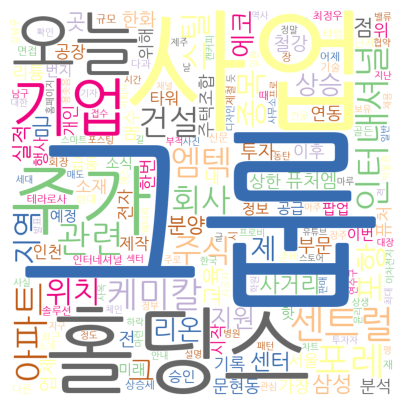

In [31]:
fig = plt.figure(figsize=(5,5))
plt.imshow(wc)
plt.axis('off')
plt.show()

##### 클러스터별 워드클라우드 만들기

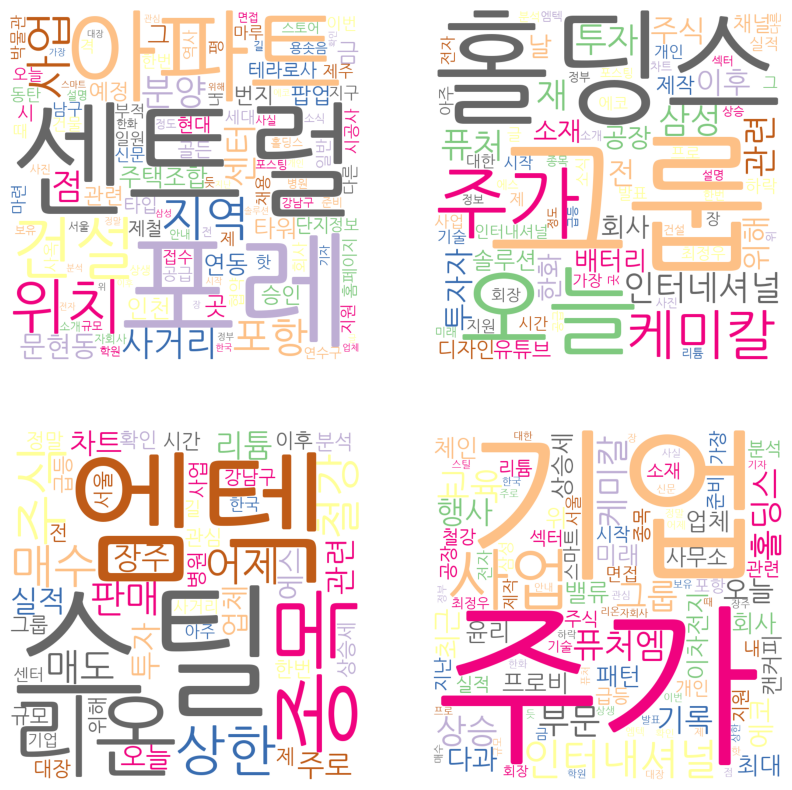

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    texts = df_descriptions.loc[df_descriptions['label']==i, "description"].to_list()
    wc = get_wordcloud(texts)
    axes[i//2, i%2].imshow(wc)
    axes[i//2, i%2].axis("off")
plt.show()